## Term Project
## DSC 630
## Abed Tabbalat

This project is to determine which model has the best accuracy to predict the outcome of diabetes. Please refer to the PDF doc for more details on the project.

In [223]:
# Base libraries
import pandas as pd
import numpy as np
from itertools import combinations
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Modeling Libraries
import yellowbrick
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler 
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix

In [172]:
# Settings
pd.set_option("display.max_rows", 10, "display.max_columns", 10)
plt.style.use('seaborn')

In [235]:
# Functions for use
## Count plot
def countplot(data, x, w=10, h=7, hue=None, ax=None, order_desc=False):
    plt.figure(figsize=(w, h))
    ax = sns.countplot(data=data, x=x, hue=hue, ax=ax, order= data[x].value_counts().index if order_desc == True else None)
    
    for patch in ax.patches:
        loc = patch.get_x()
        width = patch.get_width()
        height = patch.get_height()
        
        ax.text(loc + width / 2,height + 1, str(height), fontsize=14, color='black', ha='center', weight='bold')

## Scatter Plot        
def scatterplot(data, x, y, hue=None, ax=None):
    ax = sns.scatterplot(data=data, x=x, y=y, hue=hue, ax=ax)
    ax.set_title(f"{x} with {y}", fontsize=15, color="black")    
    if hue:
        ax.legend(prop={"size":25}, frameon=True, shadow=False)

In [174]:
# Read data
df = pd.read_csv('diabetes.csv')
df

Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin   BMI  \
0              6      148             72             35        0  33.6   
1              1       85             66             29        0  26.6   
2              8      183             64              0        0  23.3   
3              1       89             66             23       94  28.1   
4              0      137             40             35      168  43.1   
..           ...      ...            ...            ...      ...   ...   
763           10      101             76             48      180  32.9   
764            2      122             70             27        0  36.8   
765            5      121             72             23      112  26.2   
766            1      126             60              0        0  30.1   
767            1       93             70             31        0  30.4   

     DiabetesPedigreeFunction  Age  Outcome  
0                       0.627   50        1  
1                       0.351   31        0  
2                       0.672   32        1  
3                       0.167   21        0  
4                       2.288   33        1  
..                        ...  ...      ...  
763                     0.171   63        0  
764                     0.340   27        0  
765                     0.245   30        0  
766                     0.349   47        1  
767                     0.315   23        0  

[768 rows x 9 columns]

### Data Exploration

In [175]:
# Data info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


In [176]:
# Data description
df.describe().T

count        mean         std     min       25%  \
Pregnancies               768.0    3.845052    3.369578   0.000   1.00000   
Glucose                   768.0  120.894531   31.972618   0.000  99.00000   
BloodPressure             768.0   69.105469   19.355807   0.000  62.00000   
SkinThickness             768.0   20.536458   15.952218   0.000   0.00000   
Insulin                   768.0   79.799479  115.244002   0.000   0.00000   
BMI                       768.0   31.992578    7.884160   0.000  27.30000   
DiabetesPedigreeFunction  768.0    0.471876    0.331329   0.078   0.24375   
Age                       768.0   33.240885   11.760232  21.000  24.00000   
Outcome                   768.0    0.348958    0.476951   0.000   0.00000   

                               50%        75%     max  
Pregnancies                 3.0000    6.00000   17.00  
Glucose                   117.0000  140.25000  199.00  
BloodPressure              72.0000   80.00000  122.00  
SkinThickness              23.0000   32.00000   99.00  
Insulin                    30.5000  127.25000  846.00  
BMI                        32.0000   36.60000   67.10  
DiabetesPedigreeFunction    0.3725    0.62625    2.42  
Age                        29.0000   41.00000   81.00  
Outcome                     0.0000    1.00000    1.00

In [177]:
# Check for blanks
print('------- Blanks count -------')
df.isnull().sum()

------- Blanks count -------


Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64

In [178]:
# Check for duplicates in the data frame
print(f'Total duplicates: {df.duplicated().sum()}')

Total duplicates: 0


**We can determine the following:**

* There are `9` columns and `768` rows in the dataset
* All the variables are numeric
* There are no blanks within the dataset
* There are no duplicates within the dataset

*The min column in the data description table shows `0` in the variables are unexpected, further investigation required.*

**The columns that require investigation are:**

- Glucose
- BloodPressure
- SkinThickness
- Insulin
- BMI



In [179]:
# Investigating variables that show min of 0 that are unexpected
cols = ['Glucose', 'BloodPressure', 'Insulin', 'SkinThickness', 'BMI']

for c in cols:
    u_value = df[df[c] == 0]
    print(f'Count of 0 in {c}: {u_value.shape[0]}')

Count of 0 in Glucose: 5
Count of 0 in BloodPressure: 35
Count of 0 in Insulin: 374
Count of 0 in SkinThickness: 227
Count of 0 in BMI: 11


*Converting `0` to `NaN` will be the option taken to solve this issue*

In [180]:
# 0 -> Nan
df[cols] = df[cols].replace (0, np.nan)

In [181]:
# Total NaN's per variable
df.isna().sum()

Pregnancies                   0
Glucose                       5
BloodPressure                35
SkinThickness               227
Insulin                     374
BMI                          11
DiabetesPedigreeFunction      0
Age                           0
Outcome                       0
dtype: int64

In [182]:
# Checking min column in description to see results
df.describe().T

count        mean         std     min       25%  \
Pregnancies               768.0    3.845052    3.369578   0.000   1.00000   
Glucose                   763.0  121.686763   30.535641  44.000  99.00000   
BloodPressure             733.0   72.405184   12.382158  24.000  64.00000   
SkinThickness             541.0   29.153420   10.476982   7.000  22.00000   
Insulin                   394.0  155.548223  118.775855  14.000  76.25000   
BMI                       757.0   32.457464    6.924988  18.200  27.50000   
DiabetesPedigreeFunction  768.0    0.471876    0.331329   0.078   0.24375   
Age                       768.0   33.240885   11.760232  21.000  24.00000   
Outcome                   768.0    0.348958    0.476951   0.000   0.00000   

                               50%        75%     max  
Pregnancies                 3.0000    6.00000   17.00  
Glucose                   117.0000  141.00000  199.00  
BloodPressure              72.0000   80.00000  122.00  
SkinThickness              29.0000   36.00000   99.00  
Insulin                   125.0000  190.00000  846.00  
BMI                        32.3000   36.60000   67.10  
DiabetesPedigreeFunction    0.3725    0.62625    2.42  
Age                        29.0000   41.00000   81.00  
Outcome                     0.0000    1.00000    1.00

*Min values in the unexpected columns are now fixed*

*Additional data exploration required by checking the skewness of the data to determine what the NaN values need to be replaced with*

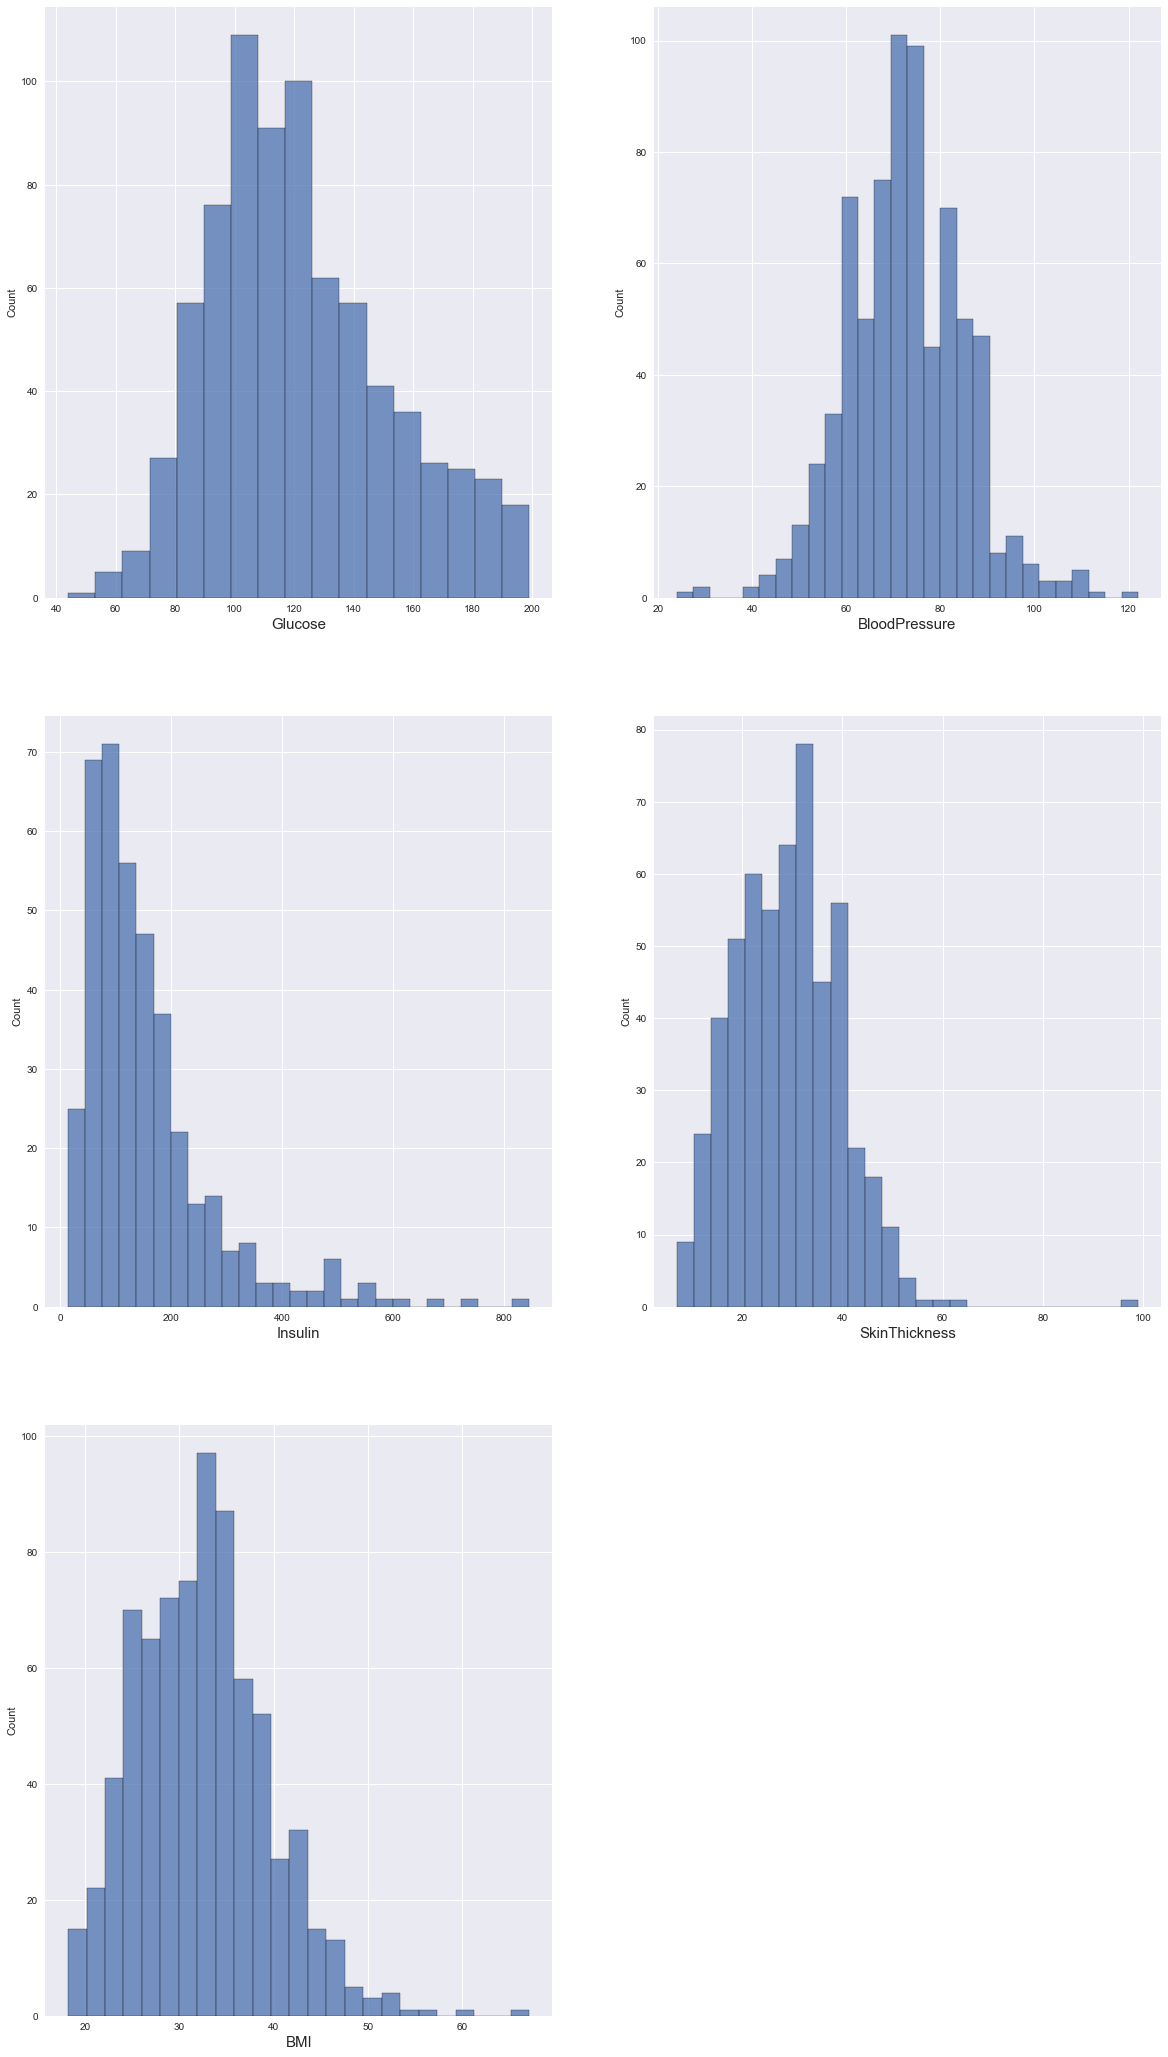

In [183]:
# Histogram to determine the data distribution to replace the NaNs
plt.figure(figsize=(20,50))
for i, c in enumerate(cols):
    plt.subplot(4, 2, i+1)
    sns.histplot(data=df, x=c)
    plt.xlabel(c, fontsize=15)
    plt.xticks(fontsize=10)

*Based on the graphs skewness we can determine if we use mean or median.*

**The decision based on the histograms above are:**

- Glucose **->** Right Skewed **->** Median
- BloodPressure **->** Normal **->** Median
- Insulin **->** Right Skewed **->** Median
- SkinThickness **->** Right Skewed **->** Median
- BMI **->** Right Skewed **->** Median

In [184]:
# Applying replacements for NaN's
for c in cols:
    df[c] = df[c].fillna(df[c].median())
    
df.isna().sum()

Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64

*Final step of the data cleaning process would be finding out the outliers within all the variables excluding `Outcome` since it is the variable we are trying to predict.*

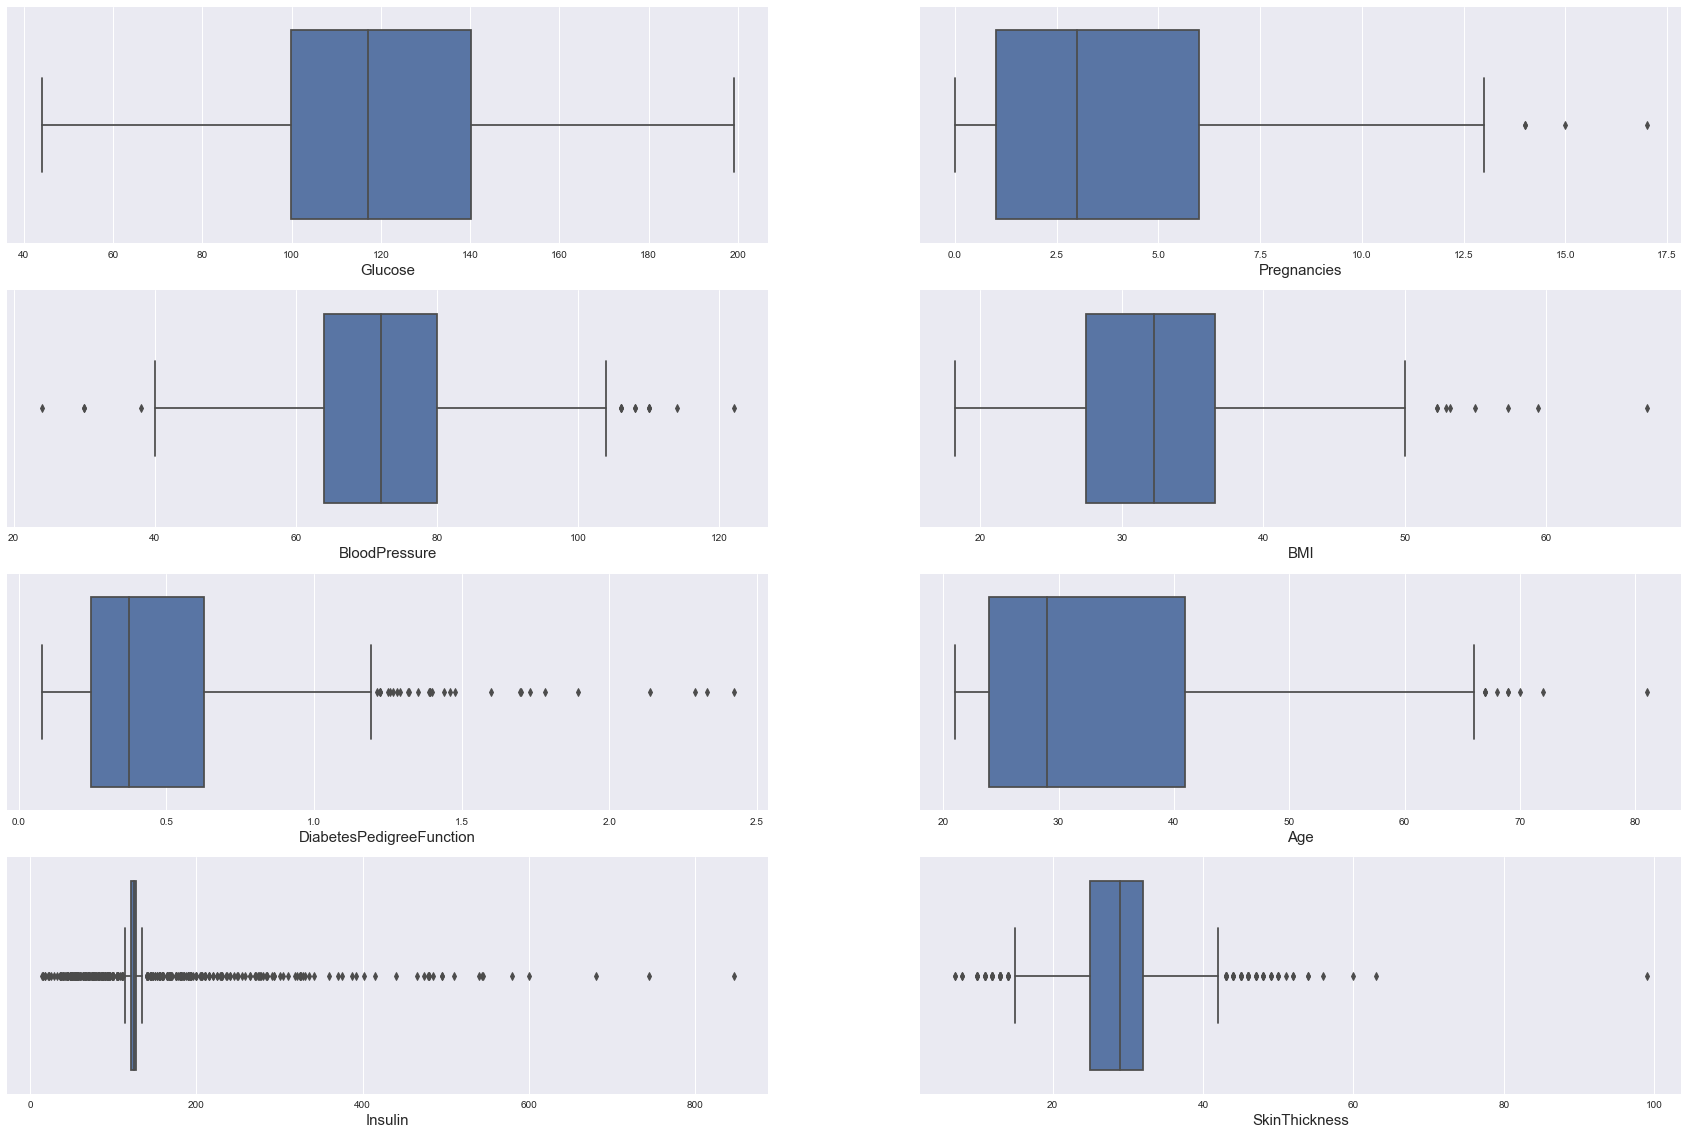

In [185]:
# Boxplot after outlier fix
plt.figure(figsize=(30,20))
for i, c in enumerate(set(df.columns)-{'Outcome'}):
    plt.subplot(4, 2, i+1)
    sns.boxplot(data=df, x=c)
    plt.xlabel(c, fontsize=15)
    plt.xticks(fontsize=10)

In [186]:
# Detecting outliers
outliers = [] 
for c in list(set(df.select_dtypes(include=np.number).columns)-{'Outcome'}):
    q1 = df[c].quantile(0.25)
    q3 = df[c].quantile(0.75)
    iqr = q3 - q1
    fence_low = q1 - (1.5*iqr)
    fence_high = q3 + (1.5*iqr)
    N_O_O = df.loc[(df[c] < fence_low) | (df[c] > fence_high)].shape[0]
                   
    df.loc[(df[c] < fence_low),c] = fence_low
    df.loc[(df[c] > fence_high),c] = fence_high
 
    df[c] = np.where((df[c] > fence_high) | (df[c] > fence_high),df[c].median(),df[c])
    outliers.append([c, N_O_O, df[c].all() < fence_high])

df_outliers = pd.DataFrame(outliers, columns=['Variable', 'No Outliers', 'Handle Status'])
df_outliers

Variable  No Outliers  Handle Status
0                   Glucose            0           True
1               Pregnancies            4           True
2             BloodPressure           14           True
3                       BMI            8           True
4  DiabetesPedigreeFunction           29           True
5                       Age            9           True
6                   Insulin          346           True
7             SkinThickness           87           True

*Now that outliers are handled, we will re-run the boxplot to check*

In [187]:
# Box Plot after outliers being taken care of
plt.figure(figsize=(30,20))
for i, c in enumerate(set(df.columns)-{'Outcome'}):
    plt.subplot(4, 2, i+1)
    sns.boxplot(data=df, x=c)
    plt.xlabel(c, fontsize=15)
    plt.xticks(fontsize=10)

*Now that outliers are dealt with, we can explore some meaning behind the data.*

*Will start with looking at the target variable and how it is split.*

In [188]:
# Countplot to compare people who are positive with diabetes vs negative
countplot(df, 'Outcome')
p_outcome = df['Outcome'][df['Outcome'] == 1].count() / df['Outcome'].count() * 100
n_outcome = df['Outcome'][df['Outcome'] == 0].count() / df['Outcome'].count() * 100

print(f'\nPostive Outcome Percentage: {p_outcome} %')
print(f'Negative Outcome Percentage: {n_outcome} %\n')


Postive Outcome Percentage: 34.89583333333333 %
Negative Outcome Percentage: 65.10416666666666 %



*Pregnancy can be good example to perform a count plot since the range would be limited*

In [236]:
# Creating weighted percentage for positive outcome and plotting the count between Pregnancies and Outcome
countplot(df, 'Pregnancies', 20, 10, hue='Outcome')

pd.set_option("display.max_rows", None, "display.max_columns", None)

p_df = df[['Pregnancies', 'Outcome']]
p_df = p_df[p_df['Outcome'] == 1]
p_df = p_df.groupby('Pregnancies').count().reset_index()
p_df['Outcome_Pct'] = p_df['Outcome'] / p_df['Outcome'].sum() * 100

print(f'\n{p_df}')
print(f'\nTotal Outcome: {p_df["Outcome"].sum()}')
print(f'Total Outcome_Pct Check: {p_df["Outcome_Pct"].sum()}\n')

posx and posy should be finite values
posx and posy should be finite values



    Pregnancies  Outcome  Outcome_Pct
0           0.0       38    14.179104
1           1.0       29    10.820896
2           2.0       19     7.089552
3           3.0       27    10.074627
4           4.0       23     8.582090
5           5.0       21     7.835821
6           6.0       16     5.970149
7           7.0       25     9.328358
8           8.0       22     8.208955
9           9.0       18     6.716418
10         10.0       10     3.731343
11         11.0        7     2.611940
12         12.0        4     1.492537
13         13.0        5     1.865672
14         13.5        4     1.492537

Total Outcome: 268
Total Outcome_Pct Check: 99.99999999999999



*We can determine that the highest positive outcomes relative to pregnancies are the ones with `0` pregnancies, which is `14.18%` of the total positive outcome in within the data.*

*Next step would be a correlation matrix between the variables to determine which variables are strongly correlated to `Outcome`.*

In [211]:
# Correlation Matrix
plt.figure(figsize=(15,10))
sns.heatmap(df.corr(), annot=True, fmt='.2f', annot_kws={'fontsize' : 18})

<AxesSubplot:>

**Heatmap shows a high positive correlation between the following:**

- Glucose and Outcome
- Pregnancies and Age
- SkinThickness and BMI

*Now that we know which variables are highly correlated, a scatter plot showing the details would be beneficial.*

In [209]:
plt.figure(figsize=(15,40))
# Glucose and Outcome plot
plt.subplot(3, 1, 1)
scatterplot(df, x='Glucose', y='Outcome')

# Pregnancies and Age
plt.subplot(3, 1, 2)
scatterplot(df, x='Age', y='Pregnancies')

# SkinThickness and BMI
plt.subplot(3, 1, 3)
scatterplot(df, x='BMI', y='SkinThickness')

*The scatter plots clearly shows how if one variable increases the other would increase as well, and vise versa.*

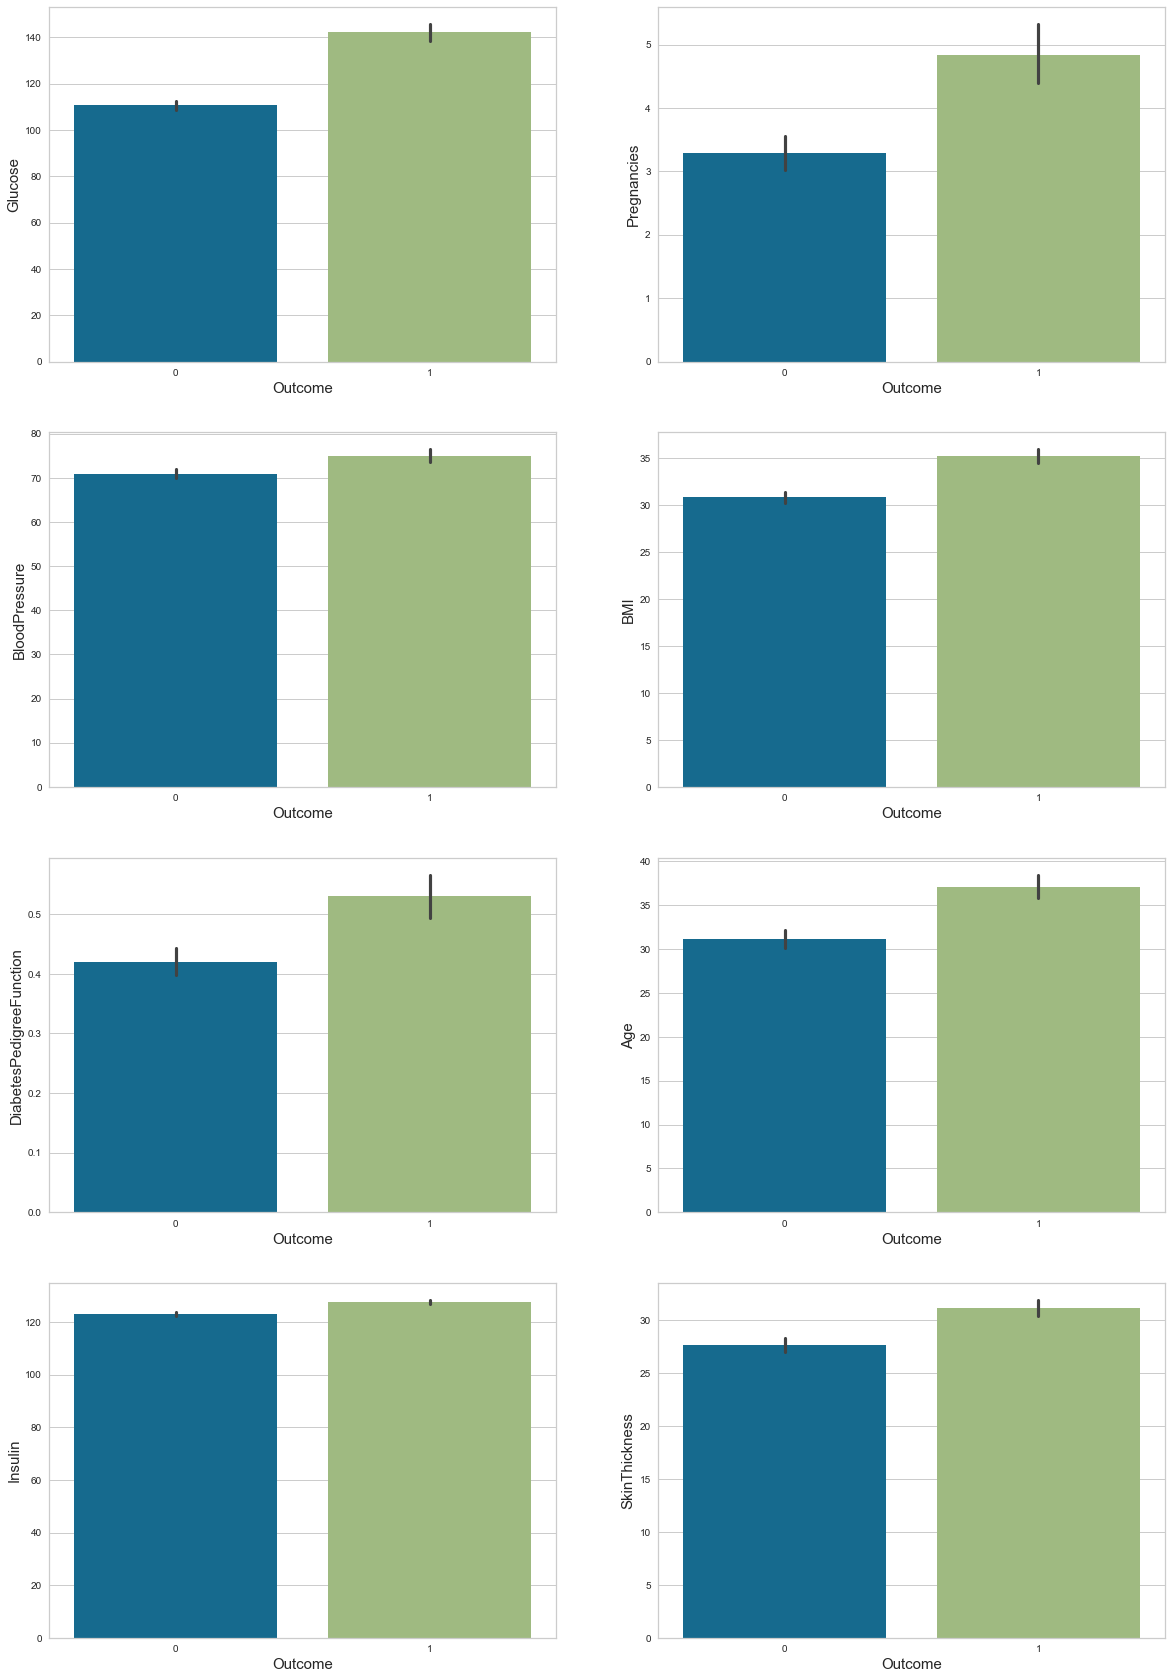

In [218]:
# Creating barcharts for all the variables against outcome to prove the relationship
plt.figure(figsize=(20,30))
for i, c in enumerate(set(df.columns)-{'Outcome'}):
    plt.subplot(4,2,i+1)
    sns.barplot(data=df, x='Outcome', y=c, )
    plt.xlabel('Outcome', fontsize=15)
    plt.xticks(fontsize=10)
    plt.ylabel(c, fontsize=15)
    plt.yticks(fontsize=10)

*The barcharts above suggest that people who are diabetic have higher values in all the variables. Meaning the higher the readings the more likely a person is diabetic.*

### Modeling

In [217]:
pd.set_option("display.max_rows", 10, "display.max_columns", 10)
# Data overview
df

Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin   BMI  \
0            6.0    148.0           72.0           35.0  125.000  33.6   
1            1.0     85.0           66.0           29.0  125.000  26.6   
2            8.0    183.0           64.0           29.0  125.000  23.3   
3            1.0     89.0           66.0           23.0  112.875  28.1   
4            0.0    137.0           40.0           35.0  135.875  43.1   
..           ...      ...            ...            ...      ...   ...   
763         10.0    101.0           76.0           42.5  135.875  32.9   
764          2.0    122.0           70.0           27.0  125.000  36.8   
765          5.0    121.0           72.0           23.0  112.875  26.2   
766          1.0    126.0           60.0           29.0  125.000  30.1   
767          1.0     93.0           70.0           31.0  125.000  30.4   

     DiabetesPedigreeFunction   Age  Outcome  
0                       0.627  50.0        1  
1                       0.351  31.0        0  
2                       0.672  32.0        1  
3                       0.167  21.0        0  
4                       1.200  33.0        1  
..                        ...   ...      ...  
763                     0.171  63.0        0  
764                     0.340  27.0        0  
765                     0.245  30.0        0  
766                     0.349  47.0        1  
767                     0.315  23.0        0  

[768 rows x 9 columns]

In [221]:
# Splitting Outcome (target variable) out of the dataframe
X = df.drop(columns=['Outcome'])
y = df['Outcome']

print(X)
print(y)

     Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin   BMI  \
0            6.0    148.0           72.0           35.0  125.000  33.6   
1            1.0     85.0           66.0           29.0  125.000  26.6   
2            8.0    183.0           64.0           29.0  125.000  23.3   
3            1.0     89.0           66.0           23.0  112.875  28.1   
4            0.0    137.0           40.0           35.0  135.875  43.1   
..           ...      ...            ...            ...      ...   ...   
763         10.0    101.0           76.0           42.5  135.875  32.9   
764          2.0    122.0           70.0           27.0  125.000  36.8   
765          5.0    121.0           72.0           23.0  112.875  26.2   
766          1.0    126.0           60.0           29.0  125.000  30.1   
767          1.0     93.0           70.0           31.0  125.000  30.4   

     DiabetesPedigreeFunction   Age  
0                       0.627  50.0  
1                       0.351  31.0

In [238]:
#Splitting the data into training data and test data
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=60)

print(f'\n----- Shape of the splits -----')
print(f'X_train: {X_train.shape[0]} rows and {X_train.shape[1]} columns')
print(f'X_test: {X_test.shape[0]} rows and {X_test.shape[1]} columns\n')


----- Shape of the splits -----
X_train: 614 rows and 8 columns
X_test: 154 rows and 8 columns



In [234]:
# Scaling, fitting, and transforming data
ss = StandardScaler()
Xs_train = ss.fit_transform(X_train)
Xs_test = ss.transform(X_test)